# Applied Data Science - The Battle of Neighborhoods
The main idea is to leverage Foursquare location data to explore and cluster neighborhoods.

## Introduction/Business problem
_Below is provided a concise discussion of the business/data science problem and background, and who would be interested in this project._

### Definition of the problem, related background, and why it is important to solve
To maintain neighborhood compatibility when considering the design of new real estate development or renovation, it is of the essence to retain the character, or look and feel, of the neighborhood of interest. This is achieved, for example, by including a range of venues identifying the neighborhood under consideration. Determining the discriminating venue categories and frequency that distinguish a neighborhood can be a daunting task unless machine learning techniques are enlisted to analyze data that might contain, depending on the neighborhood, 200 venues categories or more. To this aim, clustering is especially useful to discover insights from unlabeled data.

### Where Foursquare location data are needed to solve or execute
Foursquare location data provides information such as the categories of the venues in the neighborhood of choice. Such data are necessary to analyze a neighborhood and determine the most common venues, information that can be fed to a clustering algorithm. By examining the clusters a determination regarding the discriminating venue categories that distinguish each cluster can be made. Moreover, information such as overall rating, number of tips, agree counts, Foursquare users and users' friends, and popular and trending spots around a venue, are available for any further analysis needed by the real estate developers.

### Description of audience and why they would care about the problem
The target audience for this data science problem is real estate developers interested in finding a neighborhood compatible with their design. The target audience cares about this problem because picking the right neighborhood is of the essence for the success of their business venture.

## Data
_Below is provided a concise description of the data that will be used to solve the problem and the source of the data._

### Postal codes
Postal codes are needed to _extract_ latitude and longitude coordinates of the neighborhoods of interest. Latitude and longitude coordinates are used to retrieve Foursquare location data containing venue information. **Source:** Wikipedia pages.
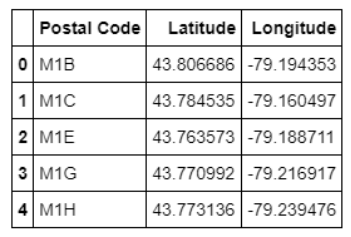
<img src="./postal_codes.png">

### Foursquare
Foursquare is a location data provider. By constructing a specific URL a request can be sent to the Foursquare API to: search for a specific type of venue around a given location, learn more about a specific venue, learn more about a specific Foursquare user, explore a given location, explore trending venues around a given location. In this case we want to _extract_, from Foursquare location data, the unique categories of the venues making up a neighborhood. This will allow for the determination of the mean of the frequency of occurrence of each category. The adopted clustering technique depends on most common venue data. **Source:** Foursquare Places API.
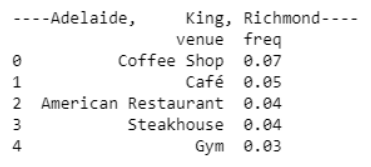
<img src="./category_frequency.png">

## Methodology
_Discussion and description of performed exploratory data analysis and machine learning used and why._

The real estate developer is interested in finding a neighborhood compatible with their design in the city of **Toronto, Ontario, Canada**.

- _Scraping_ the Wikipedia page containing a table with the postal codes of Canada.
- Transforming the data above into a _pandas dataframe_, access information from _Foursquare_ and populate the pandas dataframe.
- Clustering the neighborhood with _k-means_. Finding the optimum number of clusters with the elbow method.
- Finding the _discriminating venue categories_ that characterize each cluster.
- Using a _decision tree_ to better understand the characteristics of the clusters.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from bs4 import BeautifulSoup
import requests # library to handle requests

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

res = requests.get(url)

soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 

df = pd.read_html(str(table))[0]

df.rename(index=str,columns={0:"Postcode",1:"Borough",2:"Neighbourhood"},inplace=True)
df.drop(df.index[0],inplace=True)

df = df[df.Borough.str.contains("Not assigned")==False]

df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(lambda text: ''.join(text.to_string(index=False))).str.replace('(\\n)', ', ').reset_index()

df['Neighbourhood'].replace("Not assigned",df['Borough'],inplace=True)

df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


- Getting the latitude and the longitude coordinates of each neighborhood in order to utilize the Foursquare location data.

In [2]:
import sys
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in the IBM Cloud Object Storage. It includes my credentials.
# I will remove my credentials before sharing my notebook.
client_2f9712ee4ff84fa8a765f4ef69bfcb77 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='EddcpnuuadTpyvnVf0gaCnlVlHXZhKIj5Kwcrqq2FW45',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_2f9712ee4ff84fa8a765f4ef69bfcb77.get_object(Bucket='cp-donotdelete-pr-ww03hzaqk6vkof',Key='5-Geospatial_Coordinates.csv')['Body']

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


- Adding latitude and longitude to the dataframe.

In [3]:
df = df.merge(df_data, left_on='Postcode', right_on='Postal Code', how='outer')

df = df.drop(['Postal Code'], axis=1)

df_clu = df.drop(['Postcode'], axis=1)

df_clu.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


- Getting the geographical coordinates of Toronto.

In [4]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto, ON are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto, ON are 43.653963, -79.387207.


- Visualizing Toronto and the neighborhoods in it.

In [5]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   3.18 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  27.01 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  27.82 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  37.19 MB/s


In [6]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_clu['Latitude'], df_clu['Longitude'], df_clu['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

- Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [7]:
# The following code accesses the Foursquare API. It includes my credentials.
# I will remove my credentials before sharing my notebook.
CLIENT_ID = 'NKJJADC5GY3VXH3HHYSEDC5KK14P5JNCLWLA3YADWGHO0YKT' # your Foursquare ID
CLIENT_SECRET = 'QTBR0DUOWQ2GNMNYTXWG0BFNS5ZH1YQJMQXKC44CNKFK2QBR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

- Exploring a neighborhood in the dataframe.

In [8]:
df_clu.loc[60, 'Neighbourhood']

'Design Exchange, Toronto Dominion Centre'

- Get the neighborhood's latitude and longitude values.

In [9]:
neighborhood_latitude = df_clu.loc[60, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_clu.loc[60, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_clu.loc[60, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Design Exchange, Toronto Dominion Centre are 43.6471768, -79.38157640000001.


- Getting the top 100 venues that are in the neighborhood within a radius of 500 meters.

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5bf23e3add57975caecb9b9c'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4ad4c05df964a52059f620e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1c4941735',
         'name': 'Restaurant',
         'pluralName': 'Restaurants',
         'primary': True,
         'shortName': 'Restaurant'}],
       'id': '4ad4c05df964a52059f620e3',
       'location': {'address': '66 Wellington St West',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'at Bay Street',
        'distance': 36,
        'formattedAddress': ['66 Wellington St West (at Bay Street)',
         'Toronto ON M5K 1H6',
         'Canada'],
        'labeled

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Canoe,Restaurant,43.647452,-79.381320
1,Equinox Bay Street,Gym,43.648100,-79.379989
2,The Fairmont Royal York,Hotel,43.645449,-79.381508
3,Walrus Pub & Beer Hall,Pub,43.647375,-79.379515
4,King Taps,Gastropub,43.648476,-79.382058


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


- Creating a function to repeat the same process to all the neighborhoods in Toronto.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

- Running the above function on each neighborhood and creating a new dataframe.

In [15]:
toronto_venues = getNearbyVenues(names=df_clu['Neighbourhood'],
                                   latitudes=df_clu['Latitude'],
                                   longitudes=df_clu['Longitude'])

Rouge, Malvern
Highland Creek,     Rouge Hill,     Port Union
Guildwood, Morningside,   West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,              Ionview,         Kennedy Park
Clairlea, Golden Mile,    Oakridge
Cliffcrest,                Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre,         Wexford Heights
Maryvale,  Wexford
Agincourt
Clarks Corners,       Sullivan,  Tam O'Shanter
Agincourt North, L'Amoreaux East,        Milliken,    Steeles East
L'Amoreaux West,    Steeles West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm,     Oriole
Bayview Village
Silver Hills,   York Mills
Newtonbrook,  Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North,  Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, 

In [16]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


- Dropping neighborhood without venues available in Foursquare the from main dataframe.

In [17]:
L = []

for i in df_clu['Neighbourhood'].unique():
    if i in toronto_venues['Neighborhood'].unique():
        pass
    else:
        L.extend([i])
        print('{} does not match!'.format(i))
        
df_clu = df_clu[~df_clu['Neighbourhood'].isin(L)].reset_index(drop=True)

Upper Rouge does not match!
Newtonbrook,  Willowdale does not match!
Islington Avenue does not match!


- Checking how many venues were returned for each neighborhood.

In [18]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,57,57,57,57,57,57


- Finding out how many unique categories can be curated from all the returned venues.

In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


- Analyzing each neighborhood.

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move neighborhood column to the first column
toronto_onehot = pd.concat([toronto_onehot['Neighborhood'],toronto_onehot.drop('Neighborhood',axis=1)], axis=1)

toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

- Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.010000,0.000000,0.000000,0.000000,0.0000

- Printing each neighborhood along with the top 5 most common venues.

In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,     King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2      Thai Restaurant  0.04
3  American Restaurant  0.04
4           Steakhouse  0.04


----Agincourt----
                             venue  freq
0                   Clothing Store  0.25
1                   Breakfast Spot  0.25
2                           Lounge  0.25
3                     Skating Rink  0.25
4  Molecular Gastronomy Restaurant  0.00


----Agincourt North, L'Amoreaux East,        Milliken,    Steeles East----
               venue  freq
0         Playground   0.5
1               Park   0.5
2  Mobile Phone Shop   0.0
3      Moving Target   0.0
4      Movie Theater   0.0


----Albion Gardens, Beaumond Heights,       Humbergate,        Jamestown,      Mount Olive,      Silverstone,    South Steeles,      Thistletown----
                  venue  freq
0         Grocery Store  0.22
1        Sandwich Place  0.11
2              Pharmacy  0.11
3           P

- Writing a function to sort the venues in descending order, putting this result into a pandas dataframe, and displaying the top 10 venues for each neighborhood.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
import numpy as np # library to handle data in a vectorized manner

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Cosmetics Shop,Hotel,Bar,Asian Restaurant,Breakfast Spot
1,Agincourt,Lounge,Skating Rink,Clothing Store,Breakfast Spot,Yoga Studio,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milli...",Playground,Park,Yoga Studio,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
3,"Albion Gardens, Beaumond Heights, Humber...",Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Coffee Shop,Sandwich Place,Beer Store,Pharmacy,Gluten-free Restaurant,Deli / Bodega
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Bank,Pharmacy,Pool,Pub,Sandwich Place,Skating Rink,Gym,Airport Terminal


- Running k-means to cluster the neighborhood. Using the elbow method to find the optimum number of clusters.

In [25]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

#Elbow method
wcss = [] # minimizing within cluster sum of square (WCSS)
nofc = 30
for i in range(1,nofc):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=5, random_state=0)
    km.fit(toronto_grouped_clustering)
    wcss.append(km.inertia_)

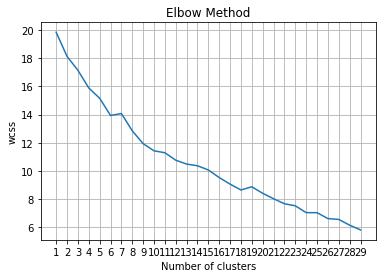

In [26]:
plt.plot(range(1,nofc),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.xticks(range(1,nofc))
plt.grid(True)
plt.show()

- Setting number of clusters to 10.

In [27]:
# set number of clusters
kclusters = 10

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, n_init = 5, random_state=0, max_iter=300).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 4, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 6, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 7, 1, 4, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 8, 1, 1, 5, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 1, 4, 1, 9, 1, 1, 7, 3, 1, 1, 1, 1, 0, 1, 1, 0, 4, 1, 0,
       0, 4, 1, 0, 0, 1, 1, 4], dtype=int32)

- Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
toronto_merged = df_clu.copy()

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood',how='inner')

toronto_merged

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Hardware Store
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1,Bar,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4,Mexican Restaurant,Pizza Place,Medical Center,Electronics Store,Breakfast Spot,Rental Car Location,Drugstore,Discount Store,Dog Run,Doner Restaurant
3,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Mexican Restaurant,Yoga Studio,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,Scarborough,Cedarbrae,43.773136,-79.239476,0,Athletics & Sports,Hakka Restaurant,Bakery,Thai Restaurant,Caribbean Restaurant,Bank,Fried Chicken Joint,Donut Shop,Dog Run,Doner Restaurant
5,Scarborough,Scarborough Village,43.744734,-79.239476,1,Playground,Grocery Store,Yoga Studio,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
6,Scarborough,"East Birchmount Park, Ionview, ...",43.727929,-79.262029,1,Discount Store,Bus Station,Department Store,Hobby Shop,Coffee Shop,Convenience Store,Train Station,Dumpling Restaurant,Dog Run,Doner Restaurant
7,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1,Bakery,Bus Line,Park,Soccer Field,Ice Cream Shop,Metro Station,Bus Station,Intersection,Yoga Studio,Doner Restaurant
8,Scarborough,"Cliffcrest, Cliffside, Scarboro...",43.716316,-79.239476,1,Motel,American Restaurant,Yoga Studio,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
9,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1,Café,General Entertainment,Skating Rink,College Stadium,Construction & Landscaping,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant


- Visualizing the resulting clusters.

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

- Examining each cluster and determining the discriminating venue categories that distinguish each cluster. Checking the centroid values by averaging the features in each cluster.

In [30]:
tg = df_clu.copy()

# add clustering labels
tg['Cluster Labels'] = kmeans.labels_

tg = tg.join(toronto_grouped.set_index('Neighborhood'), on='Neighbourhood',how='inner')

tg = tg.drop(['Latitude','Longitude'],axis=1).groupby('Cluster Labels').mean()

tg

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

- Checking how many venues are included in each cluster.

In [31]:
toronto_merged.groupby('Cluster Labels').count()

,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,13,13,13,13,13,13,13,13,13,13,13,13,13,13
1,69,69,69,69,69,69,69,69,69,69,69,69,69,69
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,9,9,9,9,9,9,9,9,9,9,9,9,9,9
5,2,2,2,2,2,2,2,2,2,2,2,2,2,2
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,2,2,2,2,2,2,2,2,2,2,2,2,2,2
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1


- Checking the centroid values by averaging the features in each cluster does not prove effective with such a high number of categories. Using a popular machine learning algorithm such as _decision tree_ to better capture and label the “essence” of clusters.

In [32]:
from sklearn.tree import DecisionTreeClassifier

X = df_clu.copy()

# add clustering labels
X['Cluster Labels'] = kmeans.labels_

X = X.join(toronto_grouped.set_index('Neighborhood'), on='Neighbourhood',how='inner') # X as the Feature Matrix

y = X['Cluster Labels'] # fill the target variable y as the response vector

y.head()

0    1
1    1
2    4
3    0
4    0
Name: Cluster Labels, dtype: int32

In [33]:
X = X.drop(['Borough', 'Neighbourhood', 'Longitude', 'Latitude', 'Cluster Labels'], axis=1)

X.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0

- Creating an instance of the DecisionTreeClassifier. Inside of the classifier, specifying criterion="entropy" to see the information gain of each node.

In [34]:
clusterTree = DecisionTreeClassifier(criterion="entropy")
clusterTree # it shows the default parameters of the learned decision tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
clusterTree.fit(X,y) #fit the data

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

- Tree visualization

In [36]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    pydotplus: 2.0.2-py_1 conda-forge

pydotplus-2.0. 100% |################################| Time: 0:00:00 782.72 kB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    python-graphviz: 0.8.4-py35_2 conda-forge

python-graphvi 100% |################################| Time: 0:00:00 920.12 kB/s


In [37]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

In [38]:
featureNames = X.columns.str.replace("&", "and")

targetNames = y.unique().tolist()

targetNames.sort()
class_names = [str(i) for i in targetNames]

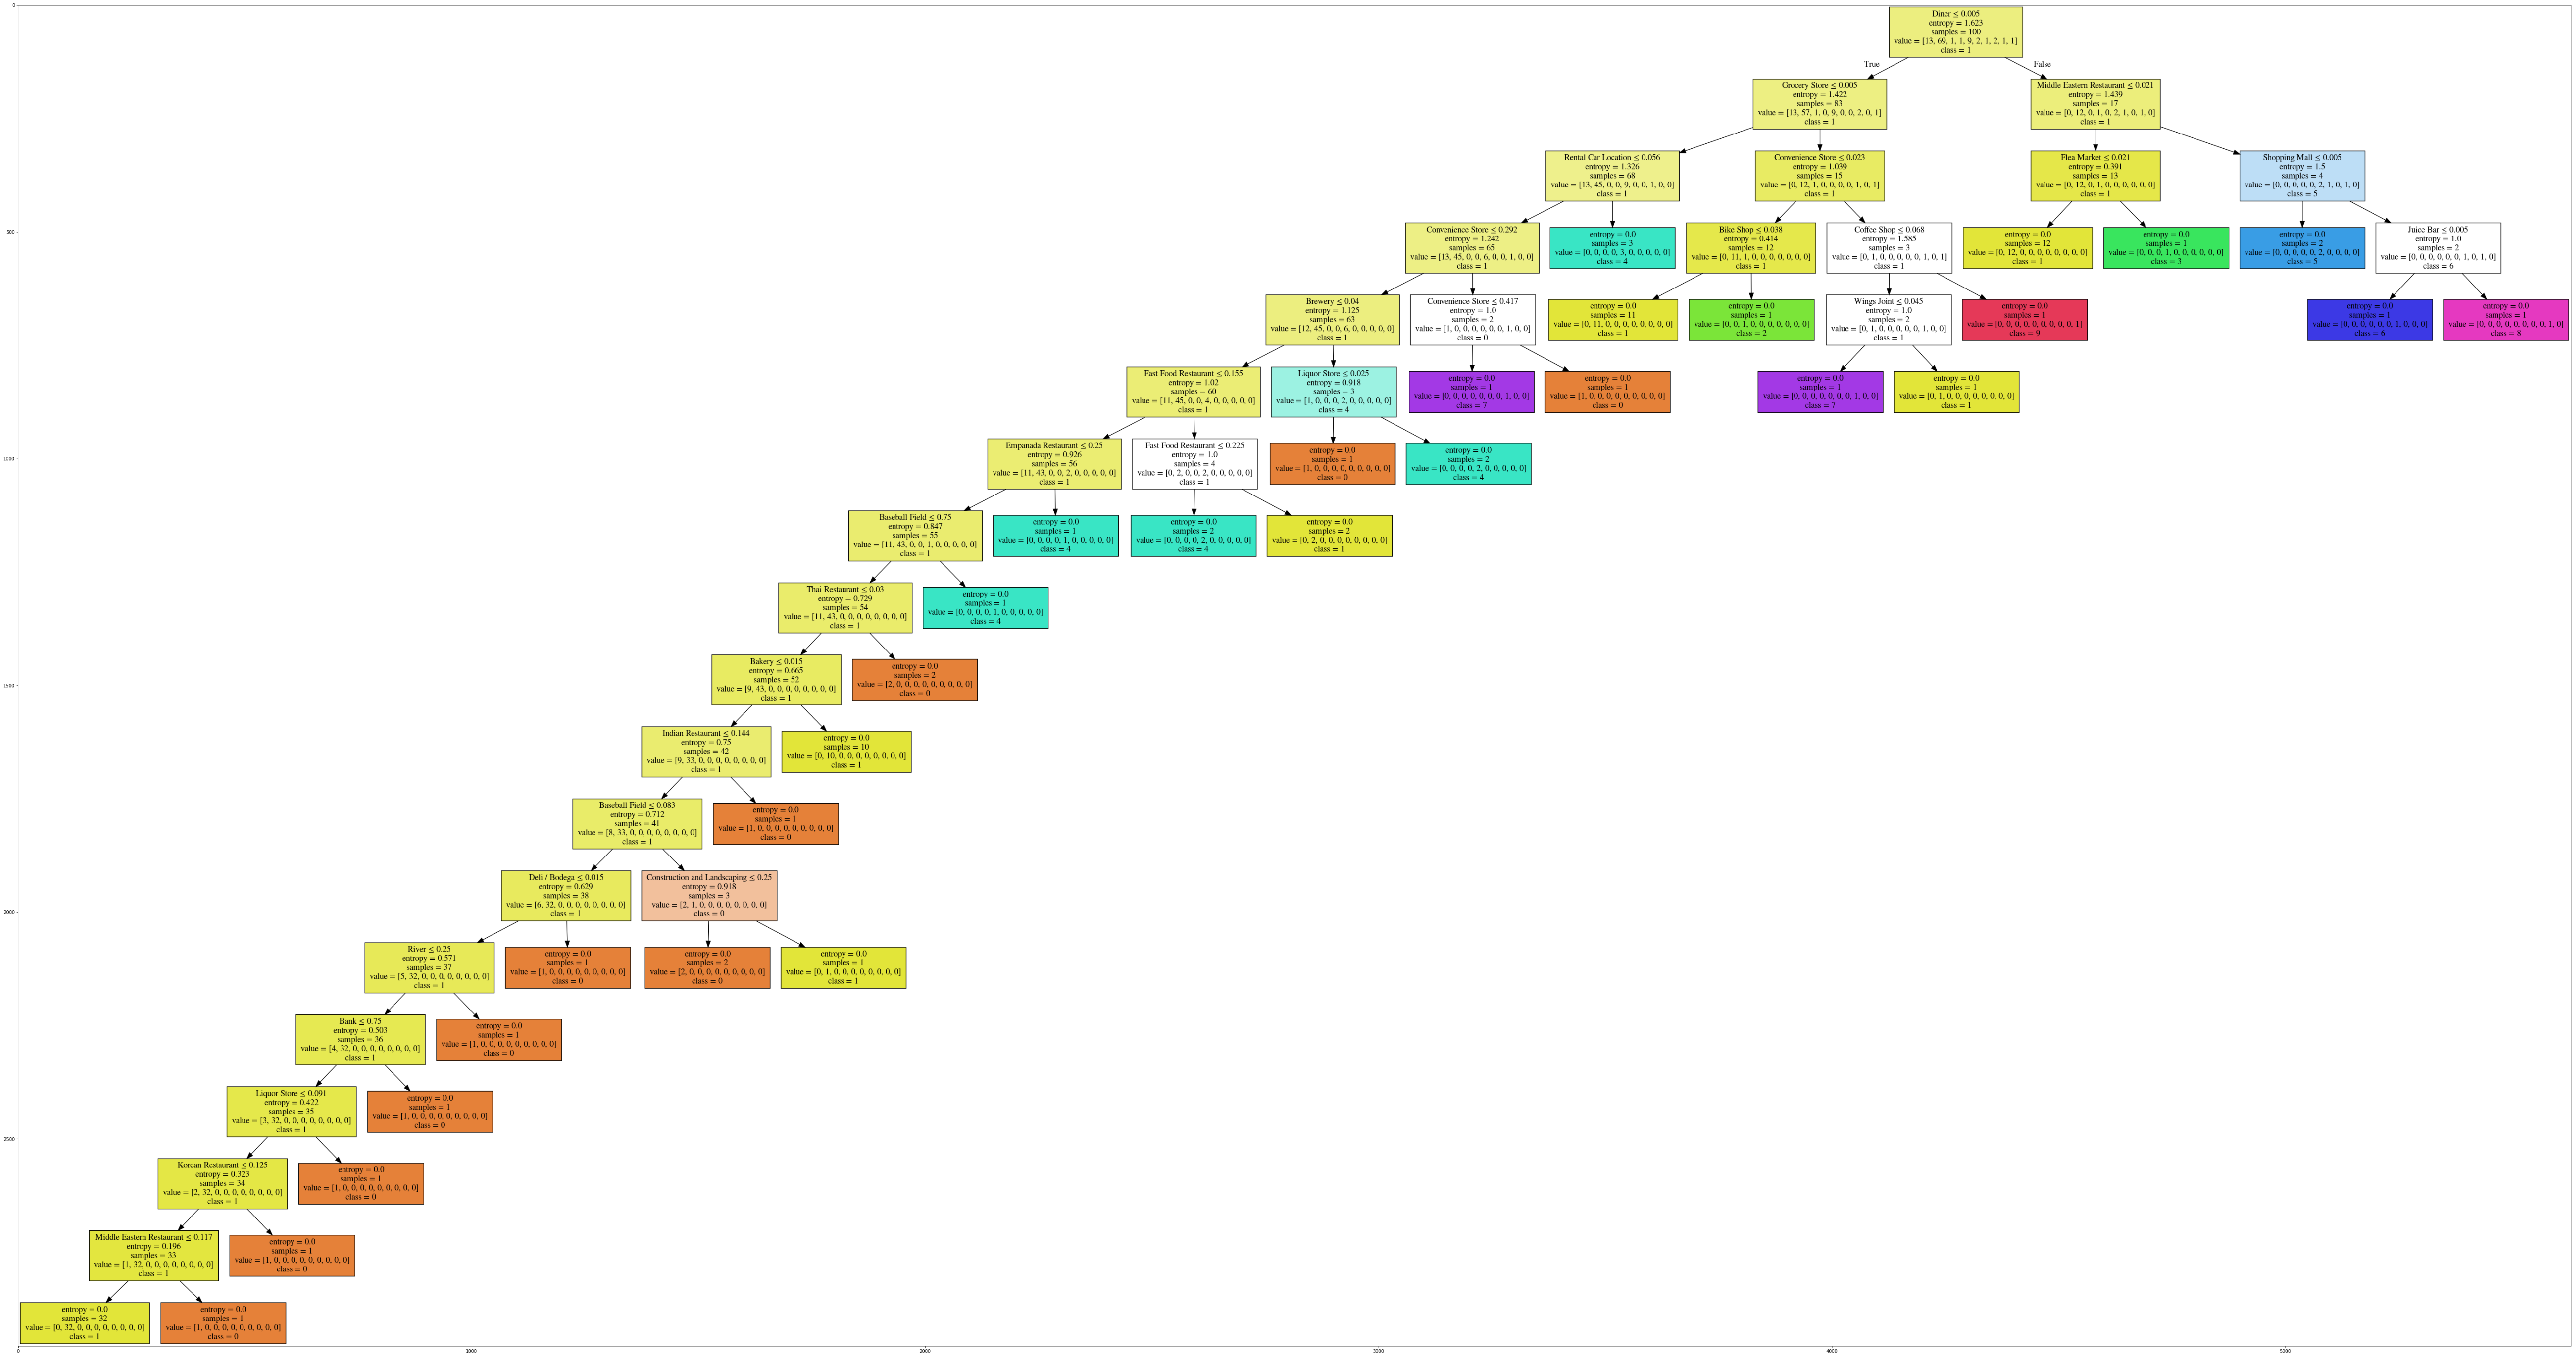

In [39]:
dot_data = StringIO()
filename = "clustertree.png"
out=tree.export_graphviz(clusterTree,feature_names=featureNames, out_file=dot_data, class_names= class_names, filled=True, special_characters=True,rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

- Creating _tgred_ 1-row Feature Matrix representing the real estate developer's design, which in this particular case is a _health food hub_.

In [40]:
zero_data = np.zeros(shape=(1,X.shape[1]))
df2 = pd.DataFrame(zero_data, columns=X.columns)
X = X.append(df2).reset_index(drop=True)

In [41]:
columns = X.columns
for col in columns:
    print(col)

Accessories Store
Adult Boutique
Afghan Restaurant
Airport
Airport Food Court
Airport Gate
Airport Lounge
Airport Service
Airport Terminal
American Restaurant
Antique Shop
Aquarium
Arepa Restaurant
Art Gallery
Art Museum
Arts & Crafts Store
Asian Restaurant
Athletics & Sports
Auto Workshop
BBQ Joint
Baby Store
Bagel Shop
Bakery
Bank
Bar
Baseball Field
Baseball Stadium
Basketball Court
Basketball Stadium
Beach
Beer Bar
Beer Store
Belgian Restaurant
Bike Shop
Bistro
Board Shop
Boat or Ferry
Bookstore
Boutique
Brazilian Restaurant
Breakfast Spot
Brewery
Bridal Shop
Bubble Tea Shop
Burger Joint
Burrito Place
Bus Line
Bus Station
Bus Stop
Butcher
Cafeteria
Café
Cajun / Creole Restaurant
Camera Store
Candy Store
Caribbean Restaurant
Cheese Shop
Chinese Restaurant
Chocolate Shop
Church
Climbing Gym
Clothing Store
Cocktail Bar
Coffee Shop
College Arts Building
College Auditorium
College Gym
College Rec Center
College Stadium
Comfort Food Restaurant
Comic Shop
Concert Hall
Construction & Landsc

In [42]:
X.loc[X.tail(1).index[0],'Café'] = 3.

In [43]:
X.loc[X.tail(1).index[0],'Cheese Shop'] = 1.

In [44]:
X.loc[X.tail(1).index[0],'Chocolate Shop'] = 1.

In [45]:
X.loc[X.tail(1).index[0],'Creperie'] = 1.

In [46]:
X.loc[X.tail(1).index[0],'Frozen Yogurt Shop'] = 1.

In [47]:
X.loc[X.tail(1).index[0],'Gastropub'] = 2.

In [48]:
X.loc[X.tail(1).index[0],'Health Food Store'] = 3.

In [49]:
X.loc[X.tail(1).index[0],'Mediterranean Restaurant'] = 1.

In [50]:
X.loc[X.tail(1).index[0],'Movie Theater'] = 1.

In [51]:
X.loc[X.tail(1).index[0],'Organic Grocery'] = 1.

In [52]:
X.loc[X.tail(1).index[0],'Park'] = 1.

In [53]:
X.loc[X.tail(1).index[0],'Playground'] = 2.

In [54]:
X.loc[X.tail(1).index[0],'Theater'] = 1.

In [55]:
X.loc[X.tail(1).index[0],'Wine Bar'] = 2.

In [56]:
X.loc[X.tail(1).index[0],'Yoga Studio'] = 3.

In [57]:
sum = X.tail(1).sum(axis=1)

In [58]:
X.loc[X.tail(1).index[0]] = X.tail(1).div(sum,axis=0).values
X.tail(1)

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [59]:
tgred = X.tail(1)

- Predicting the neighborhood compatible with real estate developer's design.

In [60]:
predNeighborhood = clusterTree.predict(tgred)
print(predNeighborhood)

[1]


## Results
_Discussion of the results._

The _decision tree_ trained on clustering results from _k-means_ predicts the real estate developer's design as belonging to **cluster 1**.

## Discussion
_Discussion of any noted observations and recommendations that can me made based on the results._

- Number of venues included in each cluster.

In [61]:
obs = toronto_merged.groupby('Cluster Labels').count()
obs.loc[:,'Neighbourhood']

Cluster Labels
0    13
1    69
2     1
3     1
4     9
5     2
6     1
7     2
8     1
9     1
Name: Neighbourhood, dtype: int64

### Observations
- Clustering (k-means): the _elbow method_ has been used to find the optimum number of clusters ensuring that data have been properly handled and interpreted.
- Decision tree: the distribution of neighborhoods across the cluster makes the likelihood of using a **biased** _train/test split_ on the decision tree very high. Following this line of reasoning, the training set used all neighborhoods available and the accuracy of the decision tree has been evaluated visually only.

### Recommendations
- The location data available allows for searching Foursquare users well acquainted (for example in terms of submitted tips, agree counts, and number of friends) with the neighborhoods of interest, i.e. those belonging to _cluster 1_. The real estate developer might consider engaging such users with a survey to better inform his decision and improve his design.
- The number of features considered in this analysis, i.e. the number of venue categories, is greater than 250. In this case the interpretation of each cluster proves difficult. The use of a _learned decision tree_ is recommended, when clustering is adopted, as an additional tool for drawing the correct conclusions. Such a approach has been followed in the presented analysis.

## Conclusions
_Conclusions of the report._

- Given the abundance of location data available to inform an important business problem such as the development of a new real estate design, the choice of finding a solution with the support of data science provided the real estate developers with unique insights.
- _Cluster 1_, predicted as the best choice for the real estate developer's design, comprises 70 neighborhoods. Such a high number of neighborhoods will provide the real estate developer with plenty of opportunities to find the needed square footage and surrounding infrastructures.

## Presentation/blog post
_Either in presentation or blog post form._
- Presentation: the work is presented to a manager or a client.
- Blog post: the work is summarized in a very elegant and intriguing way.

Link to the presentation: https://github.com/valeriomarra/IBM-Data-Science-Professional-Certificate-Specialization/blob/master/The%20Battle%20of%20Neighborhoods.pdf